<font size="6.2">Containerizing Machine Learning Applications with Dockerfile</font>

Python functions and data files needed to run this notebook are available via this [link](https://github.com/MehdiRezvandehy/multimodal_image_search_using_siglip.git).

https://github.com/docker-aiml/tech-stack-advisor

We will go through a complete end-to-end workflow for building, containerizing, and deploying a simple machine learning application for **customer churn prediction**. The steps include:

1. **Build and train a simple ML model using scikit-learn**

   * Load and preprocess a customer churn dataset (e.g., clean data, encode categorical variables, and scale features).
   * Split the data into training and test sets.
   * Train a baseline classification model such as **Logistic Regression** or **Random Forest** using scikit-learn.
   * Evaluate the model’s performance using metrics like **accuracy, precision, recall, and ROC-AUC**.
   * Save the trained model as a `.pkl` file for deployment.
   <br>
   <br>
2. **Containerize the application using a Dockerfile**

   * Write a **Dockerfile** that defines the runtime environment, dependencies, and startup command.
   * Include Python, scikit-learn, and supporting libraries such as Flask or FastAPI to serve predictions through an API.
   * Build a Docker image locally using the `docker build` command.
   * Test the container by running it locally and sending sample prediction requests via `curl` or a browser.
   <br>
   <br>
3. **Push the Docker image to Docker Hub**

   * Log in to your Docker Hub account from the terminal.
   * Tag your local image appropriately (e.g., `username/churn-prediction:latest`).
   * Push the image to your Docker Hub repository so it can be accessed remotely.
   * Verify that the image appears under your Docker Hub account.
   <br>
   <br>
4. **Deploy the Dockerized app on Hugging Face Spaces (free tier)**

   * Create a new Hugging Face Space with **Docker** as the runtime option.
   * Connect your Hugging Face account to your GitHub repository (if desired) or upload the Dockerfile and model files directly.
   * Configure the Space to automatically pull your Docker image from Docker Hub.
   * Launch the Space and test your web-based churn prediction app in a fully hosted, free environment.
   <br>
   <br>
This notebook demonstrates a **full MLOps-style pipeline** — from model training and packaging to containerized deployment — all using accessible, free tools. It’s a great hands-on project for understanding how machine learning models can move from research notebooks to real-world, shareable applications.


# 🧠 1️⃣ train_model.py

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# -----------------------------
# 1. Load dataset
# -----------------------------
# You can get the dataset from: https://www.kaggle.com/datasets/ealaxi/paysim1
# File name: PS_20174392719_1491204439457_log.csv
print("📥 Loading dataset (PaySim synthetic transaction data)...")
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

# -----------------------------
# 2. Keep relevant columns
# -----------------------------
cols = [
    'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'isFraud'
]
df = df[cols]

# -----------------------------
# 3. Encode and clean
# -----------------------------
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # e.g., TRANSFER, CASH_OUT, PAYMENT, etc.

# Replace NaN and inf
df = df.replace([float('inf'), float('-inf')], 0).fillna(0)

# -----------------------------
# 4. Split features/target
# -----------------------------
X = df.drop('isFraud', axis=1)
y = df['isFraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5. Train model
# -----------------------------
print("🧠 Training XGBoost model...")
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# -----------------------------
# 6. Evaluate
# -----------------------------
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# -----------------------------
# 7. Save model and scaler
# -----------------------------
with open("./pickles/fraud_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("./pickles/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("./pickles/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("\n✅ Model, scaler, and encoder saved successfully!")


📥 Loading dataset (PaySim synthetic transaction data)...
🧠 Training XGBoost model...

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85492
           1       0.12      0.84      0.21        44

    accuracy                           1.00     85536
   macro avg       0.56      0.92      0.61     85536
weighted avg       1.00      1.00      1.00     85536


✅ Model, scaler, and encoder saved successfully!


# 💻 2️⃣ app.py

In [3]:
import os
from pathlib import Path
from PIL import Image
import pillow_heif  # to handle HEIC/HEIF

# Register HEIF plugin for Pillow
pillow_heif.register_heif_opener()

def convert_heic_to_jpg(input_dir, output_dir=None, recursive=False,
                        max_size=None, quality=85):
    """
    Convert and compress all HEIC images to JPG.

    Args:
        input_dir (str): Folder containing HEIC files.
        output_dir (str): Folder to save JPG files (default: same as input).
        recursive (bool): Whether to process subdirectories.
        max_size (int): Maximum dimension (pixels). Example: 1200 → 1200x1200 max.
        quality (int): JPEG quality (1–100, lower = smaller file).
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir) if output_dir else input_dir
    output_dir.mkdir(parents=True, exist_ok=True)

    if not input_dir.exists():
        raise FileNotFoundError(f"Input directory not found: {input_dir}")

    pattern = "**/*.heic" if recursive else "*.heic"
    heic_files = list(input_dir.glob(pattern))

    if not heic_files:
        print("No HEIC files found.")
        return

    print(f"Found {len(heic_files)} HEIC files. Starting conversion...\n")

    for heic_path in heic_files:
        try:
            jpg_path = output_dir / heic_path.with_suffix(".jpg").name

            with Image.open(heic_path) as img:
                img = img.convert("RGB")  # ensure RGB mode

                # Optional resize to limit max dimension
                if max_size:
                    img.thumbnail((max_size, max_size))

                # Save compressed JPEG
                img.save(jpg_path, "JPEG", optimize=True, quality=quality)

            print(f"✅ Converted & Compressed: {heic_path.name} → {jpg_path.name}")
        except Exception as e:
            print(f"❌ Failed to convert {heic_path.name}: {e}")

    print("\nAll conversions complete.")


if __name__ == "__main__":
    # Example usage:
    convert_heic_to_jpg(
        input_dir="",
        output_dir="",
        recursive=True,
        max_size=1200,   # shrink large images (e.g., 4000px → 1200px max)
        quality=80       # smaller size, still good quality
    )


No HEIC files found.


In [4]:
# Launch Streamlit app
#streamlit run app.py

In [5]:
#%pip freeze > requirements.txt

# Build Container Image 

## Manual Procedure

It’s generally recommended to use a **Dockerfile** to build an image, but before doing so, we’ll first go through the **manual container build process** to understand each step involved. A Dockerfile essentially translates this manual procedure into **code**, allowing us to **automate and reproduce** the process easily. If we skip straight to automation, we lose the opportunity to understand what’s actually happening behind the scenes — how a container is built, configured, and run.

To begin, we will:

1. **Clone** the application code from the GitHub repository to the local development machine.
2. **Create a containerized development environment** using a **pre-built Maven image**, which already includes the necessary build tools.
3. **Copy** the application’s source code into the container.
4. **Connect** to the running container and perform all the steps required to build the application inside it.
5. **Run and test** the application within the container to verify that it works as expected.
6. Once everything is working correctly, **commit the container’s state** to a new image using the `docker container commit` command.

After this manual setup (see schematic illustration below), we can use a **Dockerfile** to capture the same steps in code, making the build process **repeatable, consistent, and automated**.


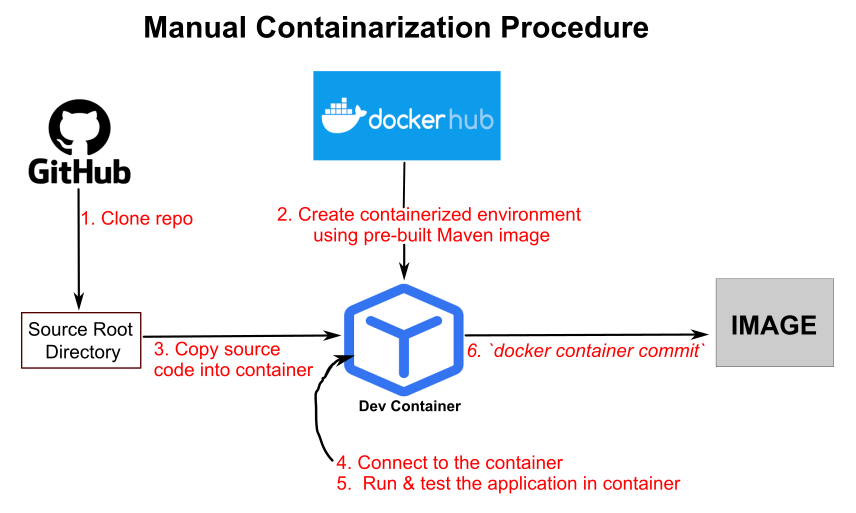

### Step 1: Clone Repo

The code repository that contains codes for fraud detection model are in  https://github.com/MehdiRezvandehy/contrizing_ml_model_with_docker.git. The pickle files should be available in repo since we are not creating again in container.

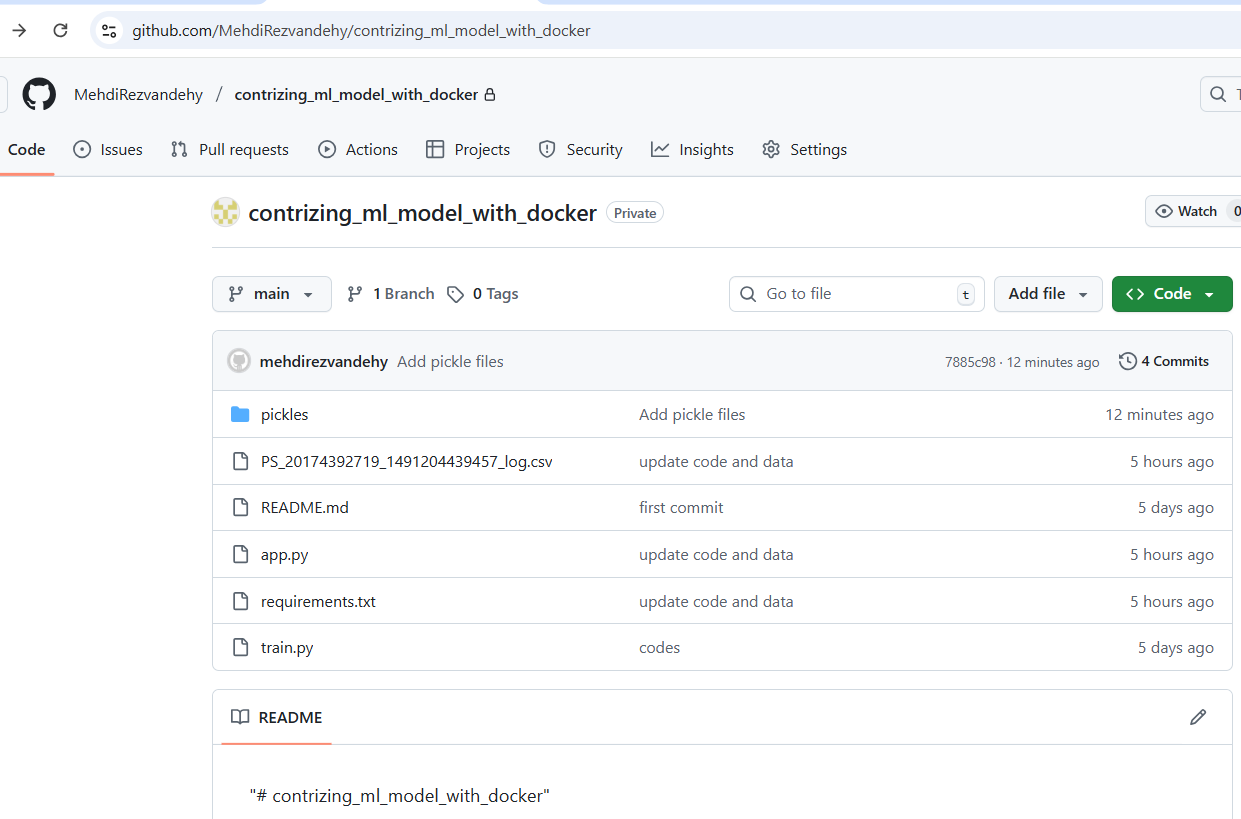

### Step 2: Create Environment 

We want to get an image from DockerHub that python has been installed
  
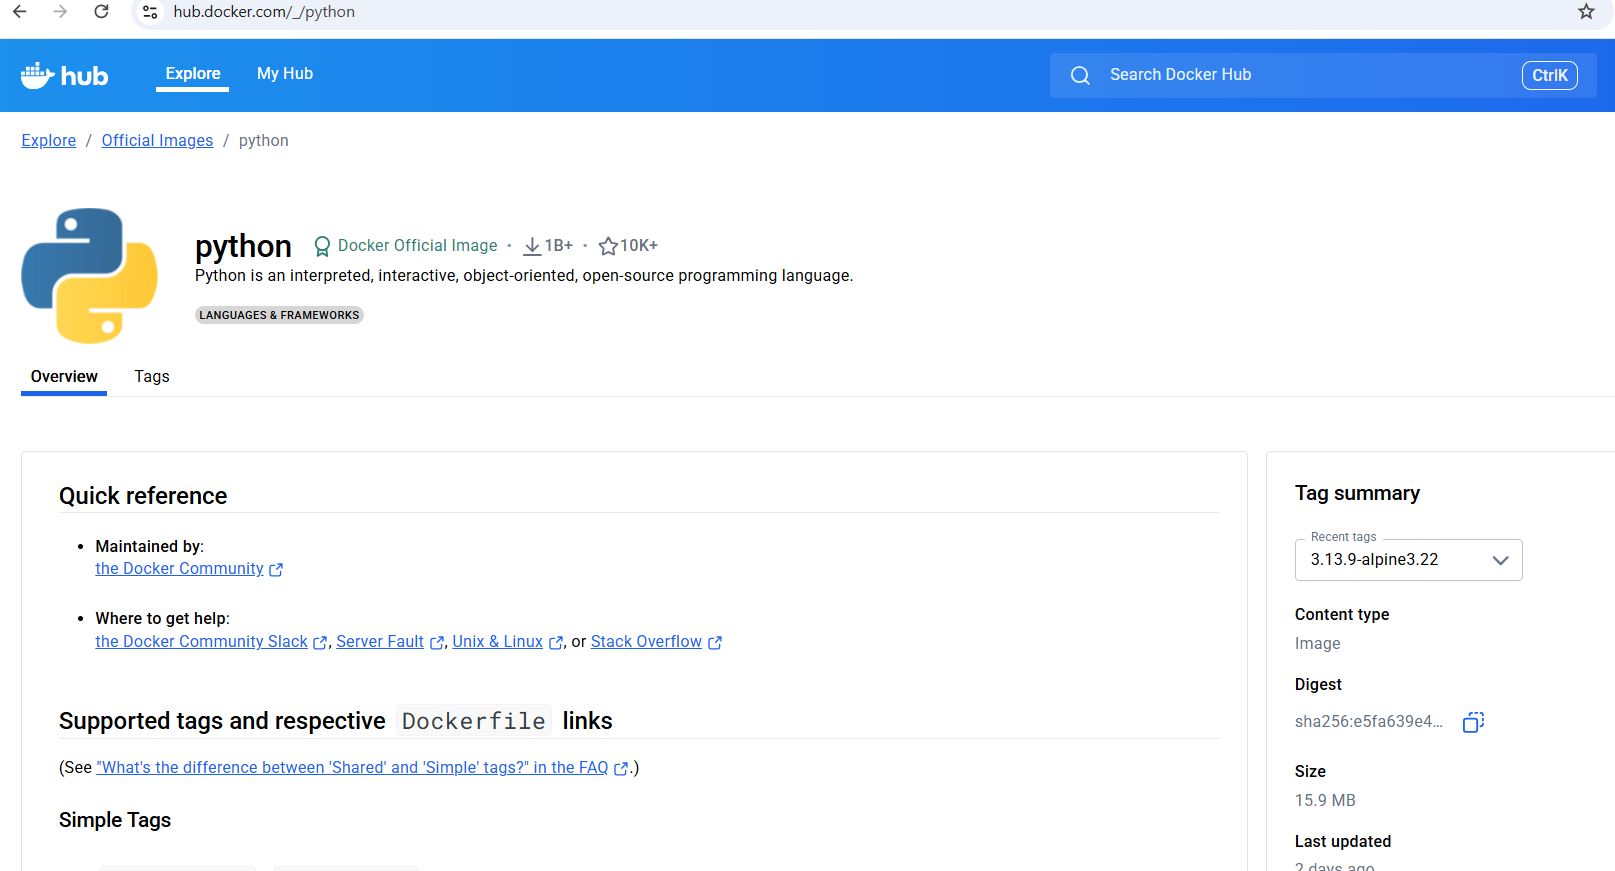

The latest version of Python 3.11 (3.11.12-slim) is used:

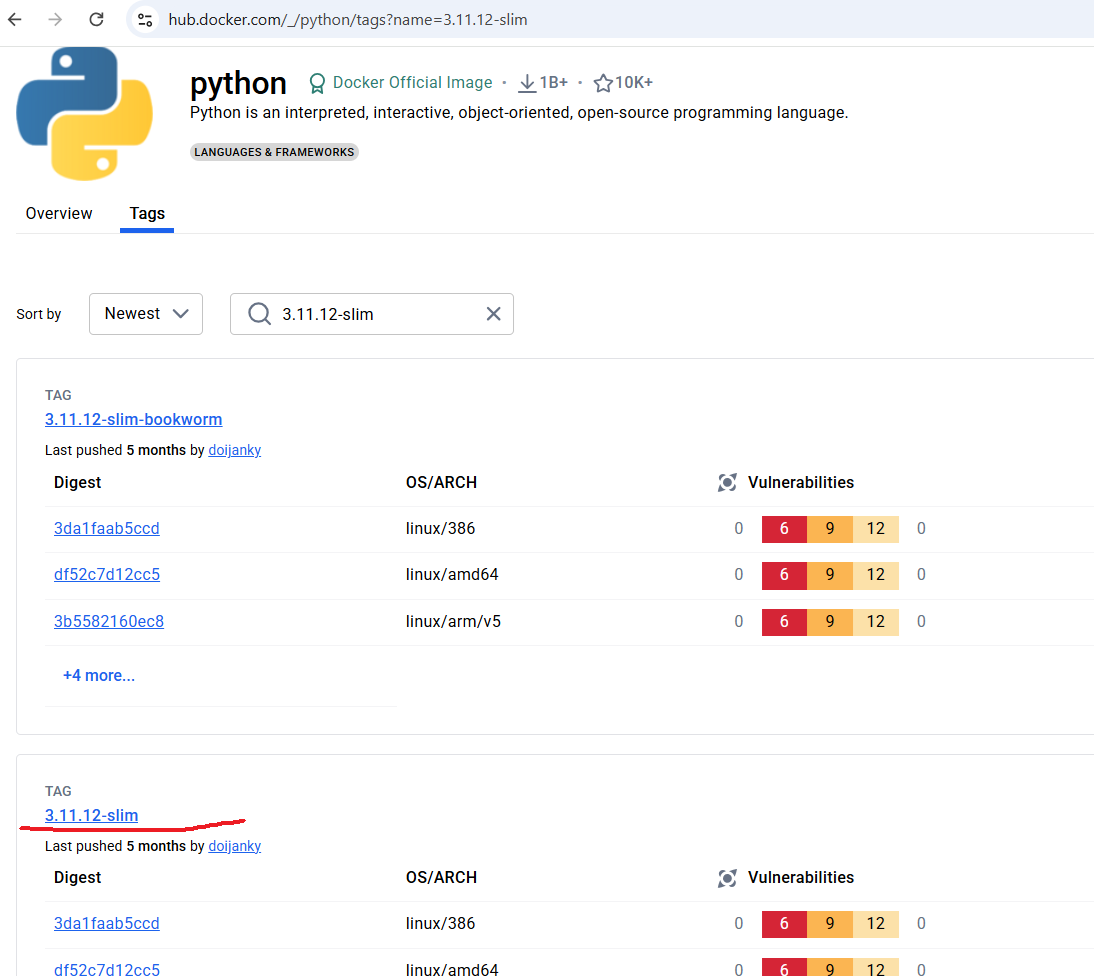

Run a dev container with `python: 3.11.12-slim` image to test build the image with `docker run -idt -p 8501:8501 --name dev_fraud_container python:3.11.12-slim `: -idt to make sure this container comes up and keeps running in background, -p is for port mapping as below:

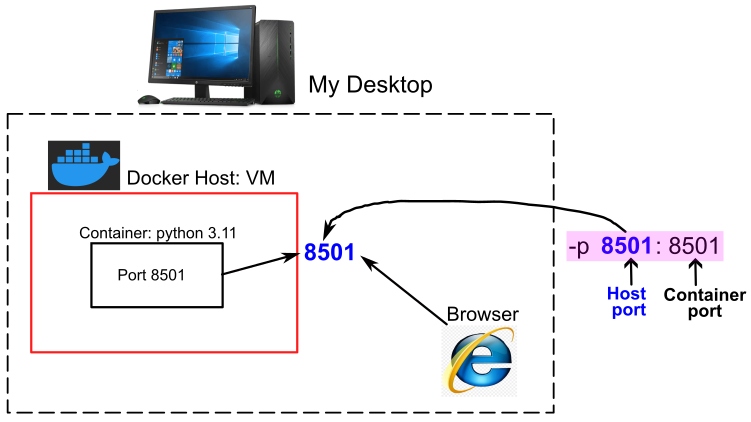

In [6]:
!docker run -idt -p 8501:8501 --name dev_fraud_container python:3.11.12-slim

1c09346b254588fb1c41ed5007ef7cdce18933ec3f7876b75c37ad4c42326d5b


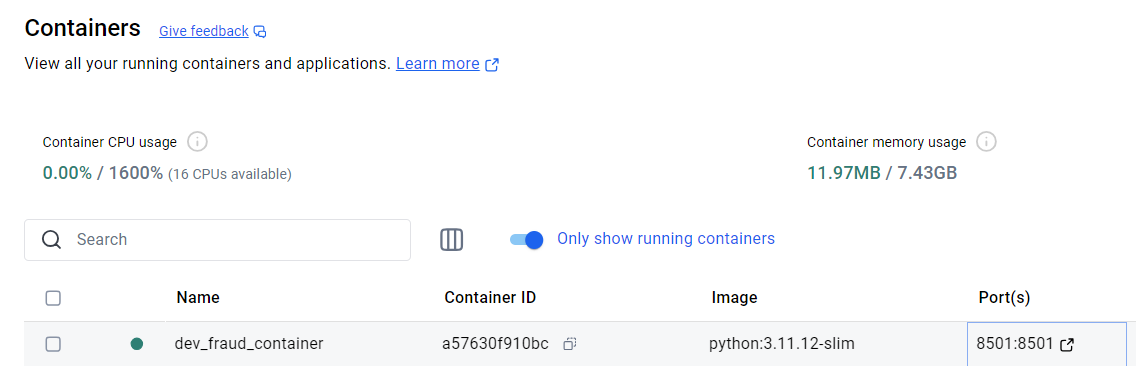

In [7]:
!docker ps

CONTAINER ID   IMAGE                                            COMMAND                  CREATED         STATUS                  PORTS                    NAMES
1c09346b2545   python:3.11.12-slim                              "python3"                1 second ago    Up Less than a second   0.0.0.0:8501->8501/tcp   dev_fraud_container
7e0b8514968a   mrezvandehy/contrizing_ml_model_with_docker:v2   "streamlit run app.pâ€¦"   5 minutes ago   Up 5 minutes            0.0.0.0:8502->8501/tcp   magical_chatelet


The container has been created, now we can use to buil the application within in. Then name of application is **dev_fraud_container**. The mapping from host side "0.0.0.0:5001" to container "5000", the image is `python:3.11.12-slim` that runs with "python3"

### Step 3: Copy the Source Code to Container

Use this code `docker cp . dev_fraud_container:/app` to copy (`cp`) everything in current path (that is the `.`) into `/app`.

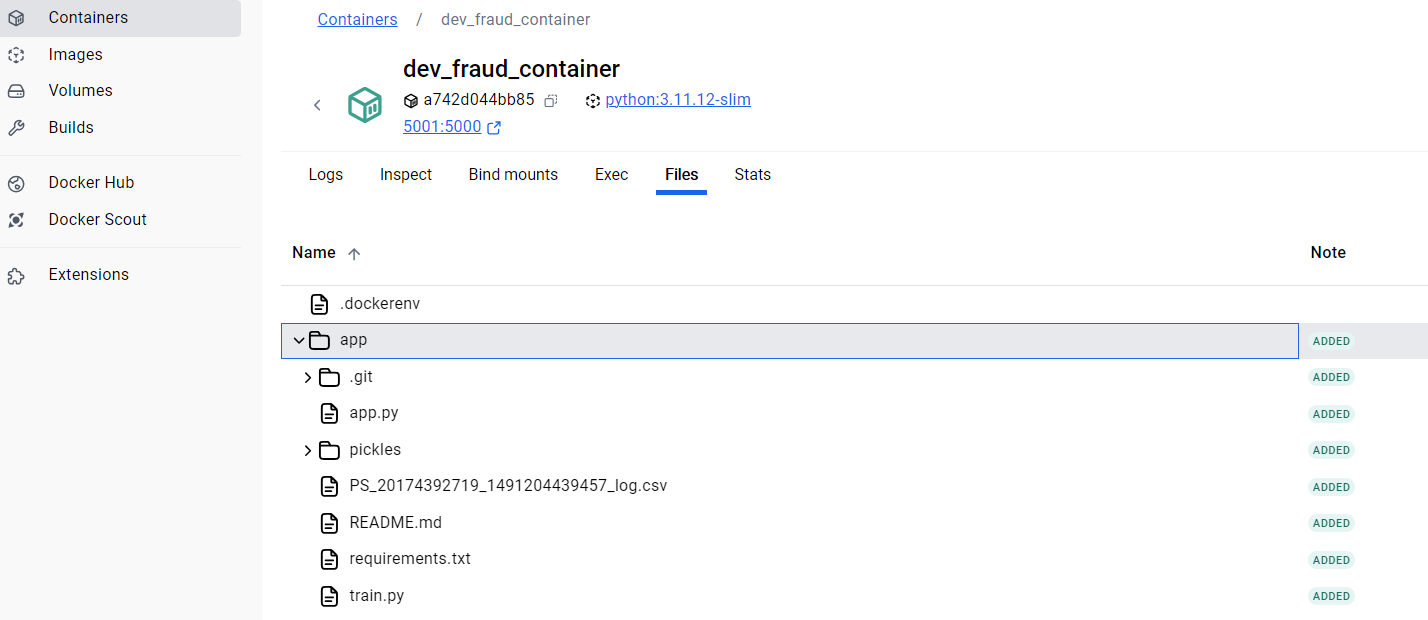

In [8]:
!docker cp . dev_fraud_container:/app

### Go Inside the Application

To go inside container, `docker exec -it dev_fraud_container bash` command using id or name should be applied. Then go to app folder:
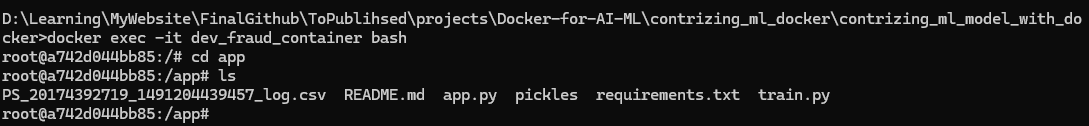

Now we are inside the container.

Next, we need to install dependencies inside container using `pip install -r requirements.txt` 
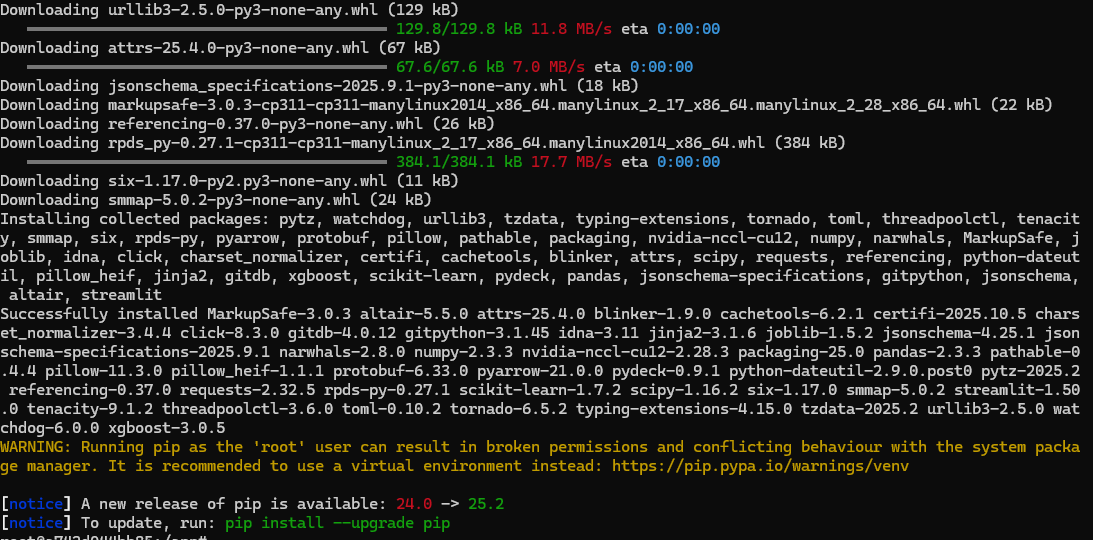

### Run App inside Container

After installing all dependencies, we can run streamlit app inside the container by `streamlit run app.py`
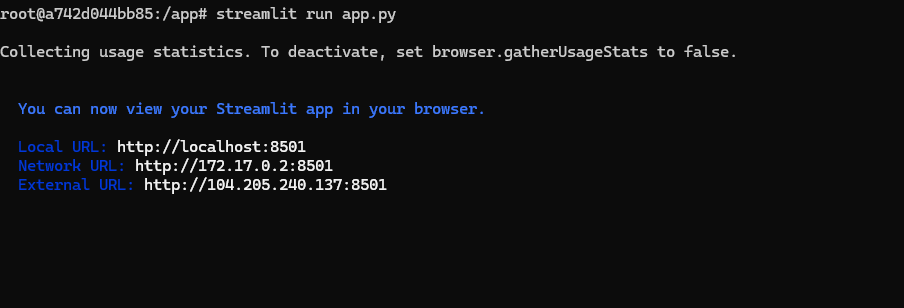

We can see the app on http://localhost:8501/ run inside the container. This means the container has everything to run the app within it.

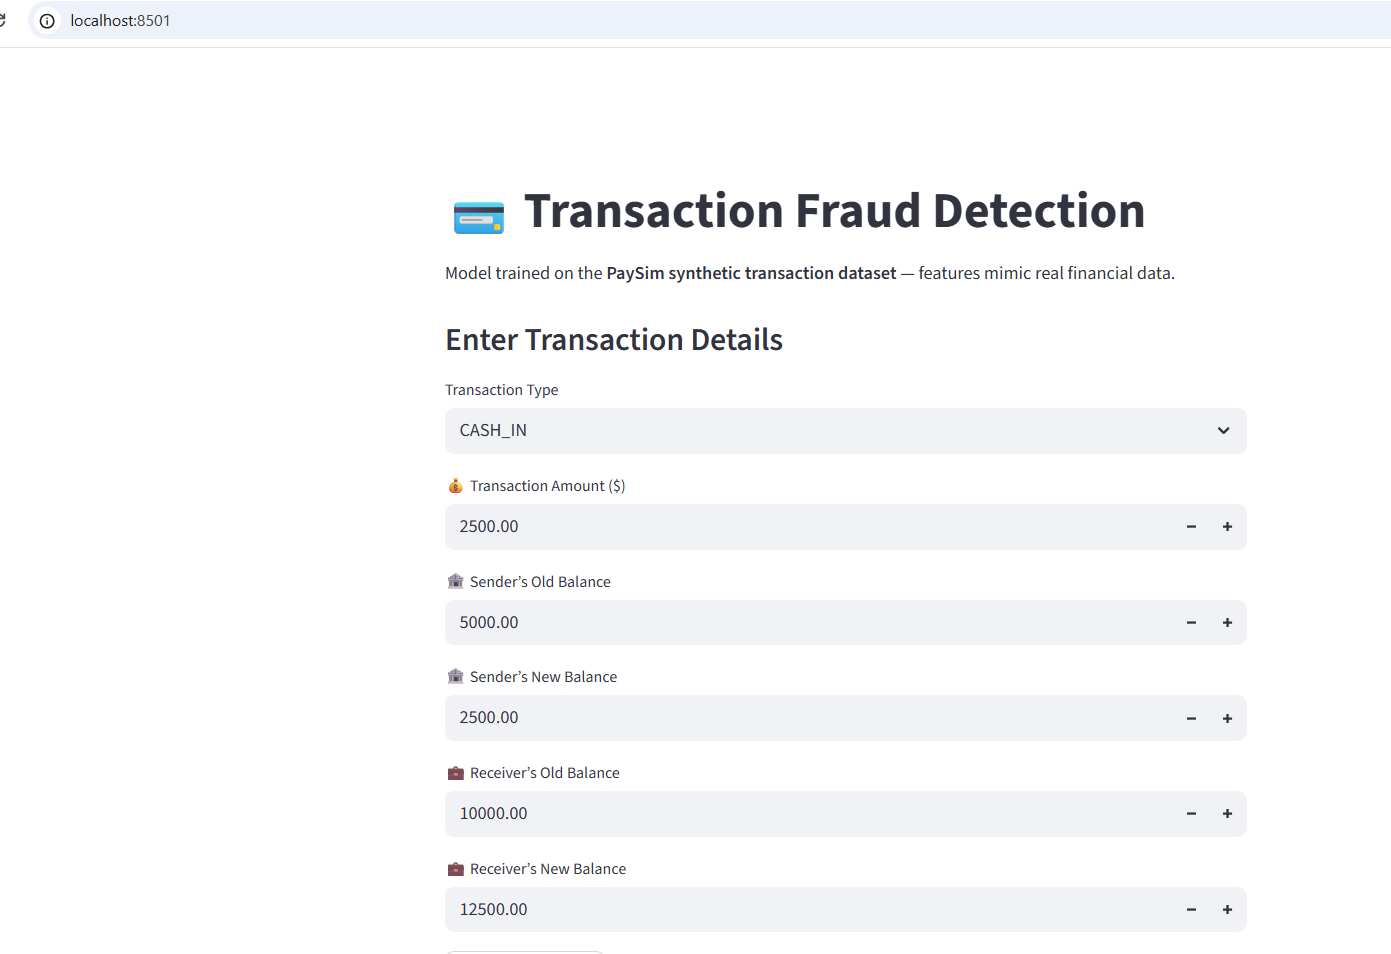

### Convert the Container to Image 

The final step is to **create a Docker image from the running container**.

First, exit the container properly:

1. Stop the app using `Ctrl + c` if it is still running.
2. Exit the container using `exit` or `Ctrl + d`.

Next, we can build an image from the container using the `docker container commit` command. It’s a good practice to include your Docker Hub username in the image name so that it can later be pushed to your Docker Hub account using the same ID.

Example command:

```bash
docker container commit dev_fraud_container docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1
```

Here:

* `mrezvandehy` is your Docker Hub username.
* `contrizing_ml_model_with_docker` is the image (and also matches your GitHub repository name).
* `v1` represents version 1 of the image.

The full image name `docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1` uniquely identifies your image in Docker Hub.


In [9]:
!docker container commit dev_fraud_container docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1

sha256:fc7aabaede430c9899c527675a7e3572003a1624f9fe267b4f98b95ed8bea717


Now we can list the images:

In [10]:
!docker image ls

REPOSITORY                                    TAG            IMAGE ID       CREATED          SIZE
mrezvandehy/contrizing_ml_model_with_docker   v1             fc7aabaede43   1 second ago     319MB
mrezvandehy/contrizing_ml_model_with_docker   v2             fd79e11f7f61   13 minutes ago   2.13GB
<none>                                        <none>         b03a8fe57b42   10 hours ago     3.3GB
<none>                                        <none>         31d85eeaeb45   10 hours ago     3.3GB
<none>                                        <none>         200c1cc7232d   6 days ago       3.21GB
<none>                                        <none>         99d4f1d48ada   6 days ago       3.21GB
<none>                                        <none>         1a6f8448fd1b   6 days ago       3.21GB
ghcr.io/mlflow/mlflow                         latest         7924215e2a80   2 weeks ago      1.25GB
ghcr.io/mlflow/mlflow                         v3.4.0         9c9e24a3fc24   5 weeks ago      1.25GB
nginx

We can push the image into registry now. First use `docker login`:

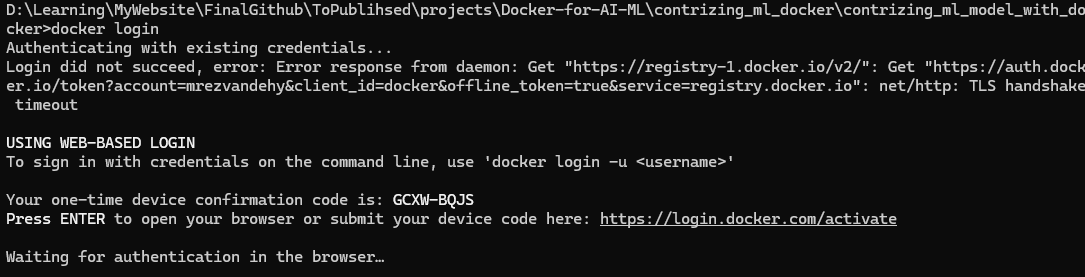

Now push the image into registry using `docker image push docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1`. This may take some time depending the size of image

In [11]:
!docker image push docker.io/mrezvandehy/contrizing_ml_model_with_docker:v1

The push refers to repository [docker.io/mrezvandehy/contrizing_ml_model_with_docker]
e3f7b5ea0481: Waiting
fa70febde0f6: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
61320b01ae5e: Waiting
61320b01ae5e: Waiting
e3f7b5ea0481: Waiting
fa70febde0f6: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
09c4893e5320: Waiting
61320b01ae5e: Waiting
e3f7b5ea0481: Waiting
fa70febde0f6: Waiting
9d545c45fb8c: Waiting
61320b01ae5e: Waiting
e3f7b5ea0481: Waiting
fa70febde0f6: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
fa70febde0f6: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
61320b01ae5e: Waiting
e3f7b5ea0481: Waiting
9d545c45fb8c: Waiting
09c4893e5320: Waiting
61320b01ae5e: Waiting
e3f7b5ea0481: Waiting
fa70febde0f6: Waiting
e3f7b5ea0481: Waiting
fa70febde0f6: Layer already exists
9d545c45fb8c: Waiting
09c4893e5320: Layer already exists
61320b01ae5e: Layer already exists
e3f7b5ea0481: Waiting
9d545c45fb8c: Layer already exists
e3f7b5ea0481: Waiting
e3f7b5ea0481: Pushed
v1: d

The image has been published to the registry, we can see it on registry. Go to your profile, you can see your image as below https://hub.docker.com/repository/docker/mrezvandehy/contrizing_ml_model_with_docker/tags:

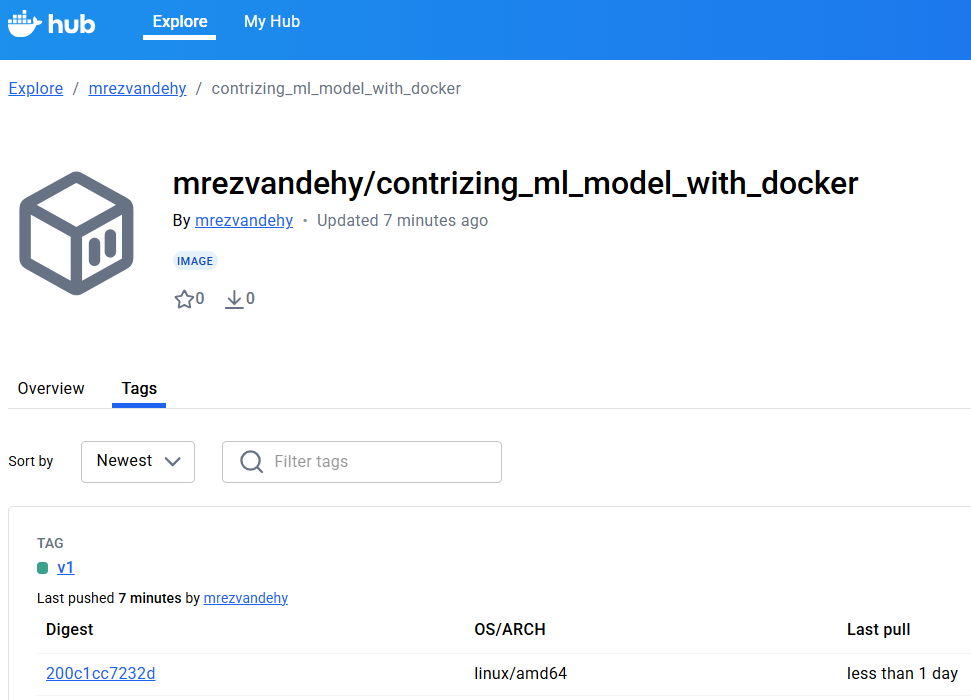

## Using Docker File

As we saw in the previous section, the manual approach to building a Docker image involves several steps. Now that we understand the process, we can convert it into code using a **Dockerfile**.

The idea is simple: we take the manual steps and write them as instructions in a Dockerfile. Then, we use the Docker build command to automatically generate the image:

```bash
docker image build -t user/repo:version .
```

This command builds the image from the Dockerfile and tags it with a name and version (for example, `mrezvandehy/contrizing_ml_model_with_docker:v1`). Once the image is successfully built, it’s ready to be **pushed to a container registry** or used directly to **launch containers** with the `docker run` command. See the schematic below:

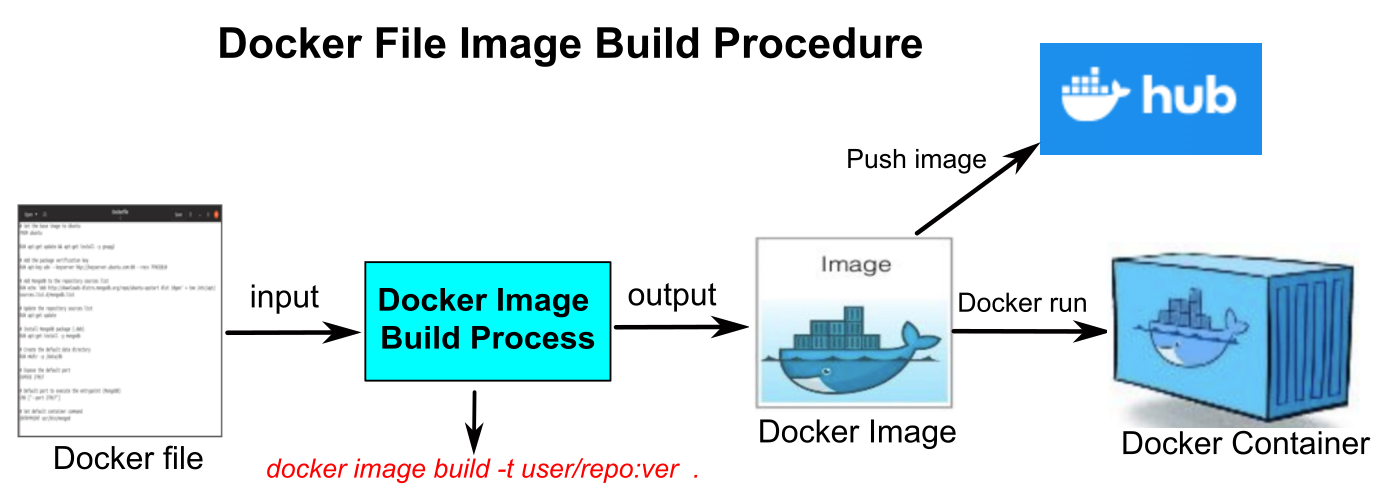

### Create Dockerfile

A **Dockerfile** is a text-based configuration file that defines how to build a Docker image. It allows you to **create images programmatically** and easily **share them** across environments.

Each line in a Dockerfile is an **instruction**, typically written in **uppercase** (e.g., `FROM`, `COPY`, `RUN`, `EXPOSE`) to distinguish it from its arguments.

A Dockerfile usually begins with a `FROM` instruction, which specifies the **base image** — the starting point for your environment. This base image can be any operating system or a pre-configured environment such as `python:3.11-slim`.

Next, you can define a **working directory** using the `WORKDIR` instruction. Files such as `requirements.txt` are then copied into this directory using `COPY`.

Each `RUN` instruction executes a command and creates a **new layer** in the image. Docker’s layered architecture allows it to **cache** and **reuse** unchanged layers, making builds faster and enabling **incremental updates** when you push or pull images.

Finally, the `EXPOSE` instruction specifies which **port** the application inside the container will listen on — for example, port `8501` for a Streamlit app.

This is a Dockerfile for streamlit app:

```dockerfile

FROM python:3.11-slim

# Set working directory
WORKDIR /app

# Copy only requirements first (for caching)
COPY requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy the rest of the app
COPY . .

# Expose the Streamlit default port
EXPOSE 8501

# Set environment variable to avoid Streamlit asking for email, etc.
ENV STREAMLIT_DISABLE_VERSION_CHECK=true \
    STREAMLIT_SERVER_HEADLESS=true \
    PYTHONUNBUFFERED=1

# Command to run the Streamlit app
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0"]

```

The docker file is the instruction we followed earlier while building the image manually.

### Build Image

Add DockerFile in root of source code:

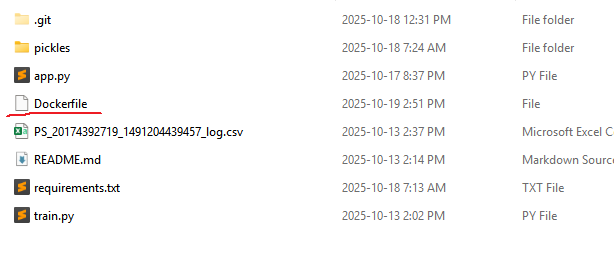

Next build an image using this command `docker image build -t docker.io/mrezvandehy/contrizing_ml_model_with_docker:v2 .` on the same directory in bash: where `-t` is tag, and `v2` is version 2:
* `mrezvandehy` is your Docker Hub username.
* `contrizing_ml_model_with_docker` is the image (and also matches your GitHub repository name).
* `v2` represents version 2 of the image.

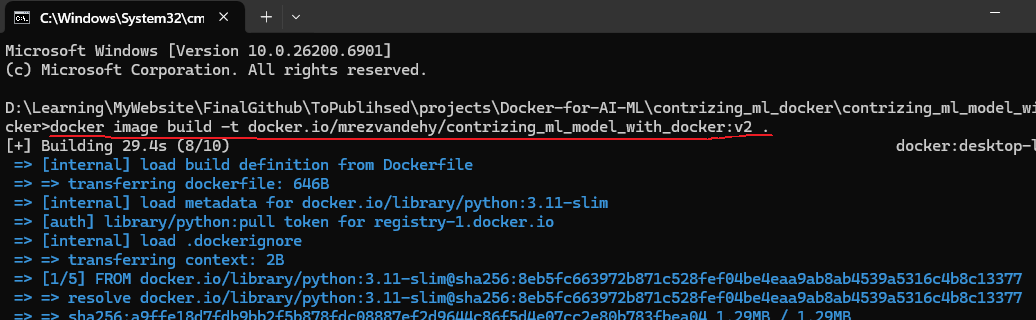

Here is running the Dockerfile:
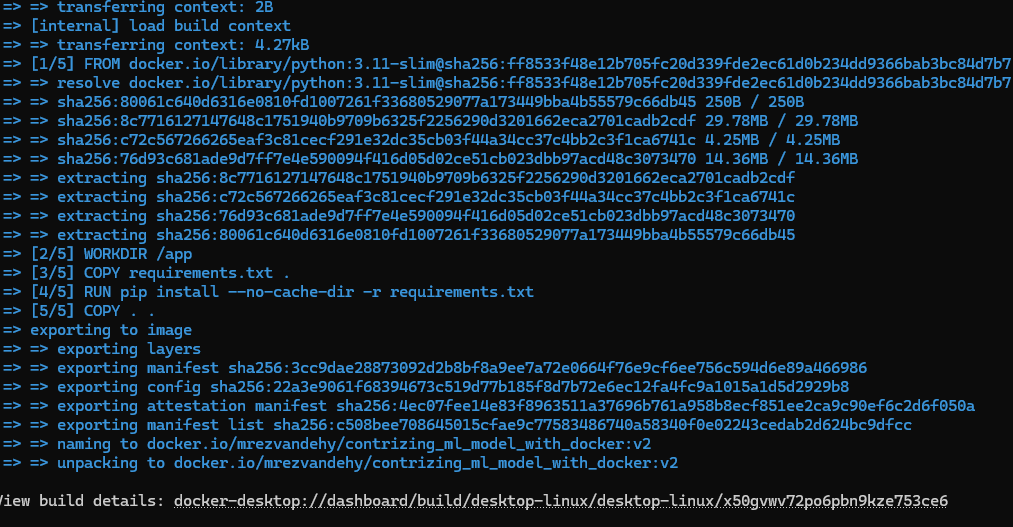

Now we can see it on Docker desktop [docker-desktop://dashboard/build/desktop-linux/desktop-linux/bsip37dnr1vuyl0ve4y9dmylc](docker-desktop://dashboard/build/desktop-linux/desktop-linux/bsip37dnr1vuyl0ve4y9dmylc):

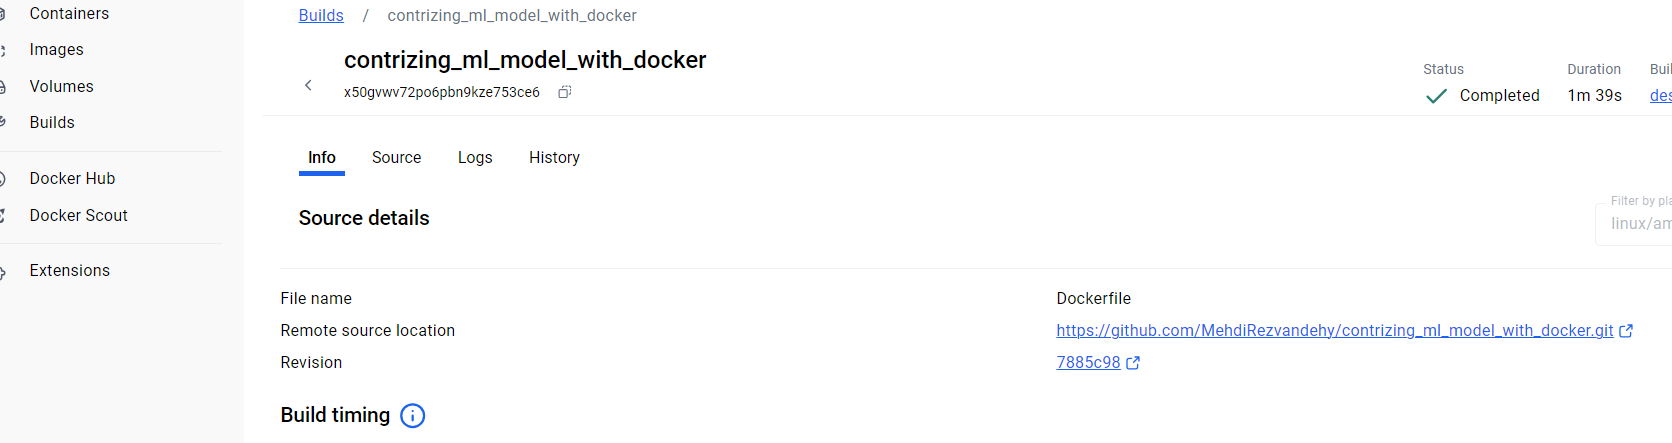

### Test Image 

Now we can launch the container out of this and see this image already works or not:

In [22]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED          SIZE
mrezvandehy/contrizing_ml_model_with_docker   v1        fc7aabaede43   13 minutes ago   319MB
mrezvandehy/contrizing_ml_model_with_docker   v2        fd79e11f7f61   26 minutes ago   2.13GB


As can be seen the v2 version has been added.

Lets test the application to see if it works or not by this command `docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2`

In [13]:
!docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2

9e1544354b9a61f1094a80e84fc3b2c8c601eafe795ec98b58800bd957ff956b


docker: Error response from daemon: driver failed programming external connectivity on endpoint determined_brown (7f72fc938e601e44aafe5450706a74c6558c1b879087ec49cbd02adaa30fb3c7): Bind for 0.0.0.0:8502 failed: port is already allocated.


The error is bacause the container `dev_fraud_container` has not be deleted. It can be done by this command `docker rm -f dev_fraud_container`

In [14]:
!docker rm -f dev_fraud_container

dev_fraud_container


In [15]:
# then run again
!docker run -idt -p 8502:8501 mrezvandehy/contrizing_ml_model_with_docker:v2

f7f241d8f24c9eda8e24a47e6c4ed5f489b1924e310c91a8191c4d6357e15a98


docker: Error response from daemon: driver failed programming external connectivity on endpoint bold_northcutt (604d1b75fd8737a1c7eb87bd9797065d1e744ba08e82de957800d2c348fec888): Bind for 0.0.0.0:8502 failed: port is already allocated.


Now it works!

In [16]:
!docker ps

CONTAINER ID   IMAGE                                            COMMAND                  CREATED         STATUS         PORTS                    NAMES
7e0b8514968a   mrezvandehy/contrizing_ml_model_with_docker:v2   "streamlit run app.pâ€¦"   5 minutes ago   Up 5 minutes   0.0.0.0:8502->8501/tcp   magical_chatelet


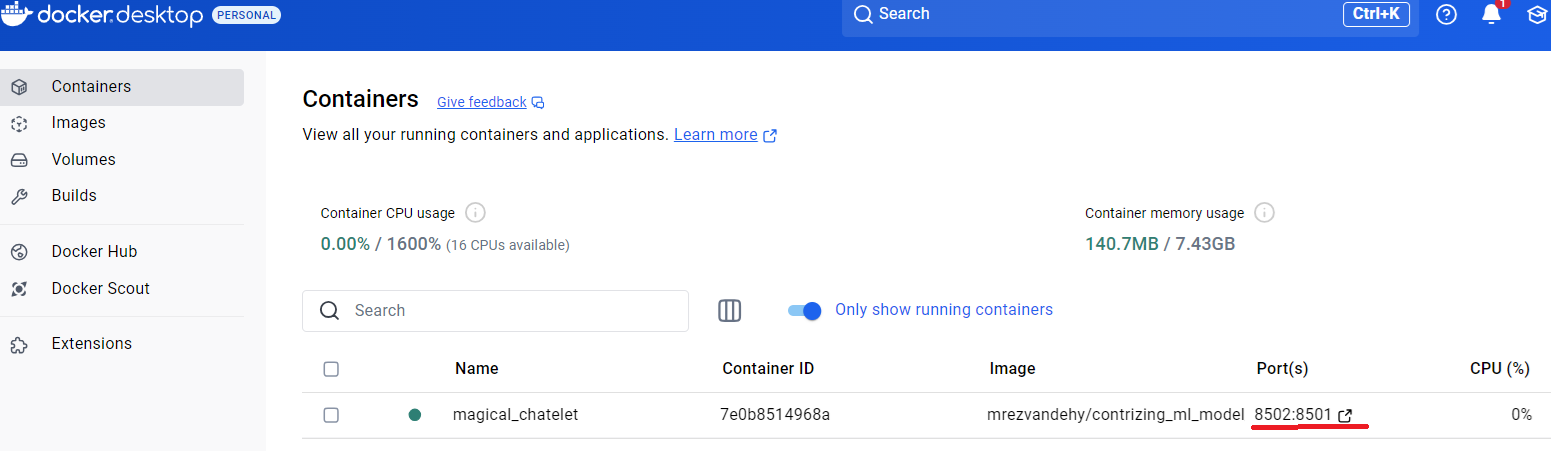

http://localhost:8502/

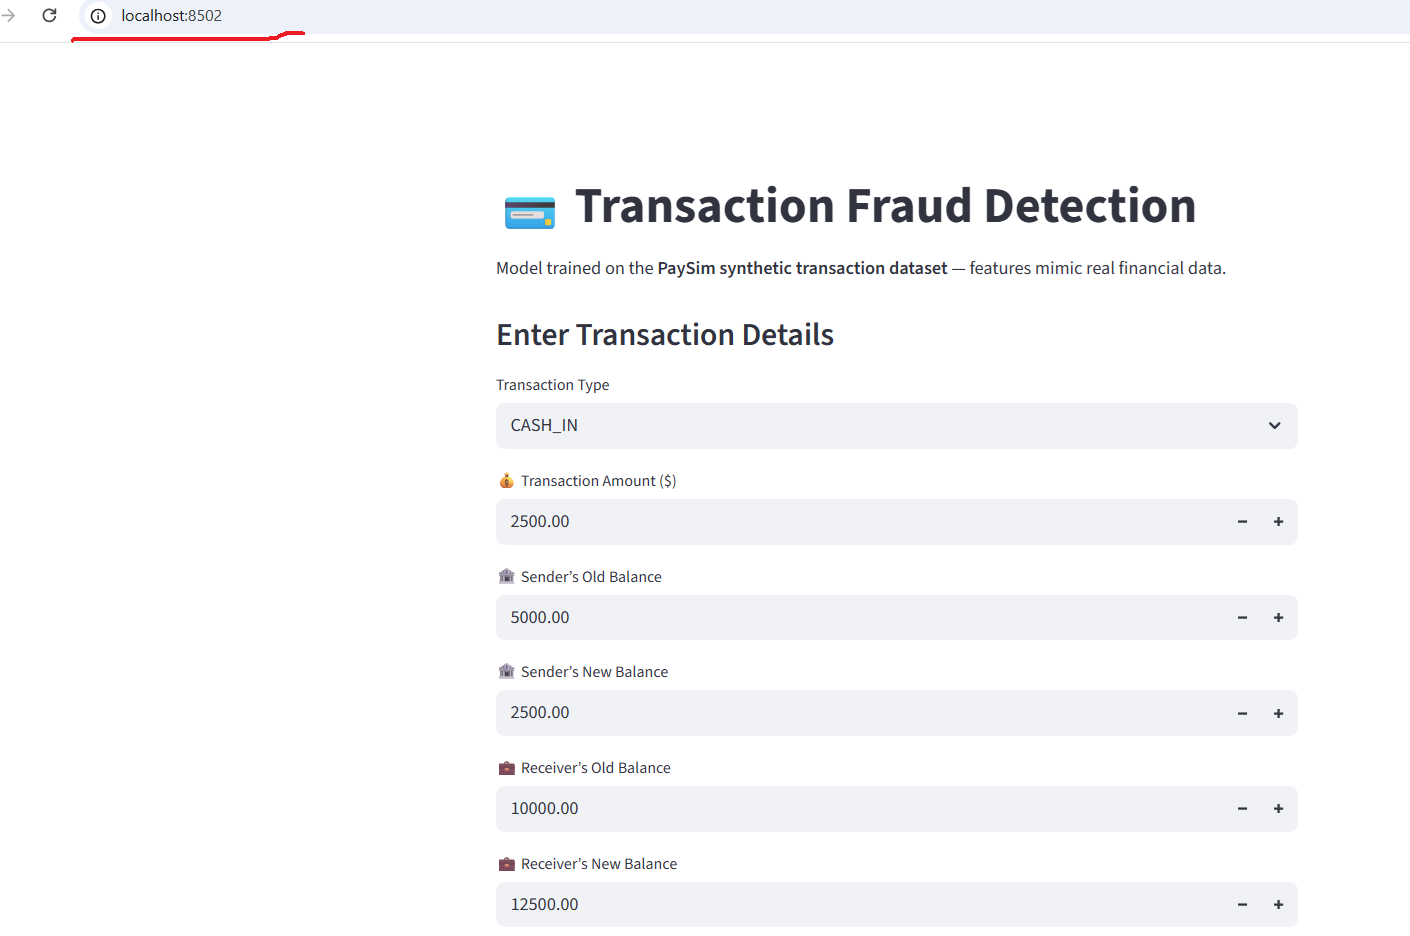

### Publish Container Image

In [21]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED          SIZE
mrezvandehy/contrizing_ml_model_with_docker   v1        fc7aabaede43   12 minutes ago   319MB
mrezvandehy/contrizing_ml_model_with_docker   v2        fd79e11f7f61   26 minutes ago   2.13GB


The version 1 (v1) is the manual procedure and version 2 (v2) is using Docker File

In [29]:
!docker history mrezvandehy/contrizing_ml_model_with_docker:v1

IMAGE          CREATED          CREATED BY                                      SIZE      COMMENT
fc7aabaede43   22 minutes ago   python3                                         83.3MB    
<missing>      5 months ago     CMD ["python3"]                                 0B        buildkit.dockerfile.v0
<missing>      5 months ago     RUN /bin/sh -c set -eux;  for src in idle3 pâ€¦   16.4kB    buildkit.dockerfile.v0
<missing>      5 months ago     RUN /bin/sh -c set -eux;   savedAptMark="$(aâ€¦   51.7MB    buildkit.dockerfile.v0
<missing>      5 months ago     ENV PYTHON_SHA256=849da87af4df137710c1796e27â€¦   0B        buildkit.dockerfile.v0
<missing>      5 months ago     ENV PYTHON_VERSION=3.11.12                      0B        buildkit.dockerfile.v0
<missing>      5 months ago     ENV GPG_KEY=A035C8C19219BA821ECEA86B64E628F8â€¦   0B        buildkit.dockerfile.v0
<missing>      5 months ago     RUN /bin/sh -c set -eux;  apt-get update;  aâ€¦   10.4MB    buildkit.dockerfile.v0
<missing> 

In [30]:
!docker history mrezvandehy/contrizing_ml_model_with_docker:v2

IMAGE          CREATED          CREATED BY                                      SIZE      COMMENT
fd79e11f7f61   36 minutes ago   CMD ["streamlit" "run" "app.py" "--server.poâ€¦   0B        buildkit.dockerfile.v0
<missing>      36 minutes ago   ENV STREAMLIT_DISABLE_VERSION_CHECK=true STRâ€¦   0B        buildkit.dockerfile.v0
<missing>      36 minutes ago   EXPOSE map[8501/tcp:{}]                         0B        buildkit.dockerfile.v0
<missing>      36 minutes ago   COPY . . # buildkit                             46MB      buildkit.dockerfile.v0
<missing>      36 minutes ago   RUN /bin/sh -c pip install --no-cache-dir -râ€¦   1.28GB    buildkit.dockerfile.v0
<missing>      37 minutes ago   COPY requirements.txt . # buildkit              12.3kB    buildkit.dockerfile.v0
<missing>      37 minutes ago   WORKDIR /app                                    8.19kB    buildkit.dockerfile.v0
<missing>      2 weeks ago      CMD ["python3"]                                 0B        buildkit.docker

Using v2, we get optimized version of the image as port 8502 can be run.

In [26]:
!docker ps

CONTAINER ID   IMAGE                                            COMMAND                  CREATED          STATUS          PORTS                    NAMES
7e0b8514968a   mrezvandehy/contrizing_ml_model_with_docker:v2   "streamlit run app.pâ€¦"   25 minutes ago   Up 25 minutes   0.0.0.0:8502->8501/tcp   magical_chatelet


In [40]:
# make v2 as latest
!docker image tag mrezvandehy/contrizing_ml_model_with_docker:v2  mrezvandehy/contrizing_ml_model_with_docker:latest

In [42]:
!docker image ls mrezvandehy/contrizing_ml_model_with_docker

REPOSITORY                                    TAG       IMAGE ID       CREATED          SIZE
mrezvandehy/contrizing_ml_model_with_docker   v1        fc7aabaede43   28 minutes ago   319MB
mrezvandehy/contrizing_ml_model_with_docker   latest    fd79e11f7f61   42 minutes ago   2.13GB
mrezvandehy/contrizing_ml_model_with_docker   v2        fd79e11f7f61   42 minutes ago   2.13GB


Now how to publish this layer `!docker image push mrezvandehy/contrizing_ml_model_with_docker:latest`. First you have to log in container

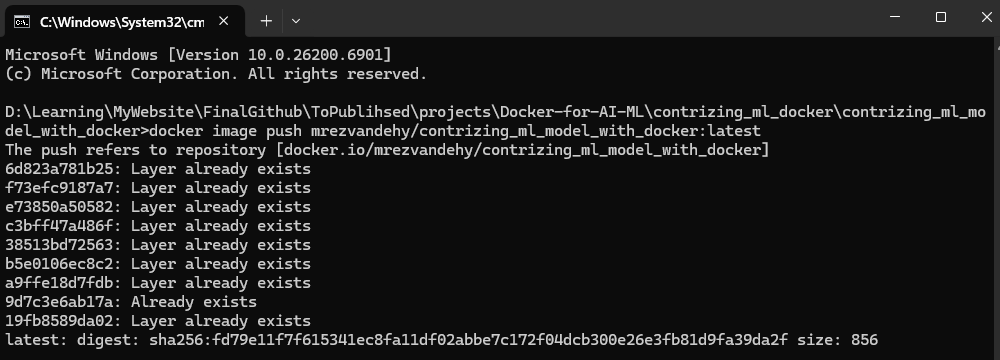

The image has been published to the registry, we can see it on registry. Go to your profile, you can see your image as below https://hub.docker.com/repository/docker/mrezvandehy/contrizing_ml_model_with_docker/tags:

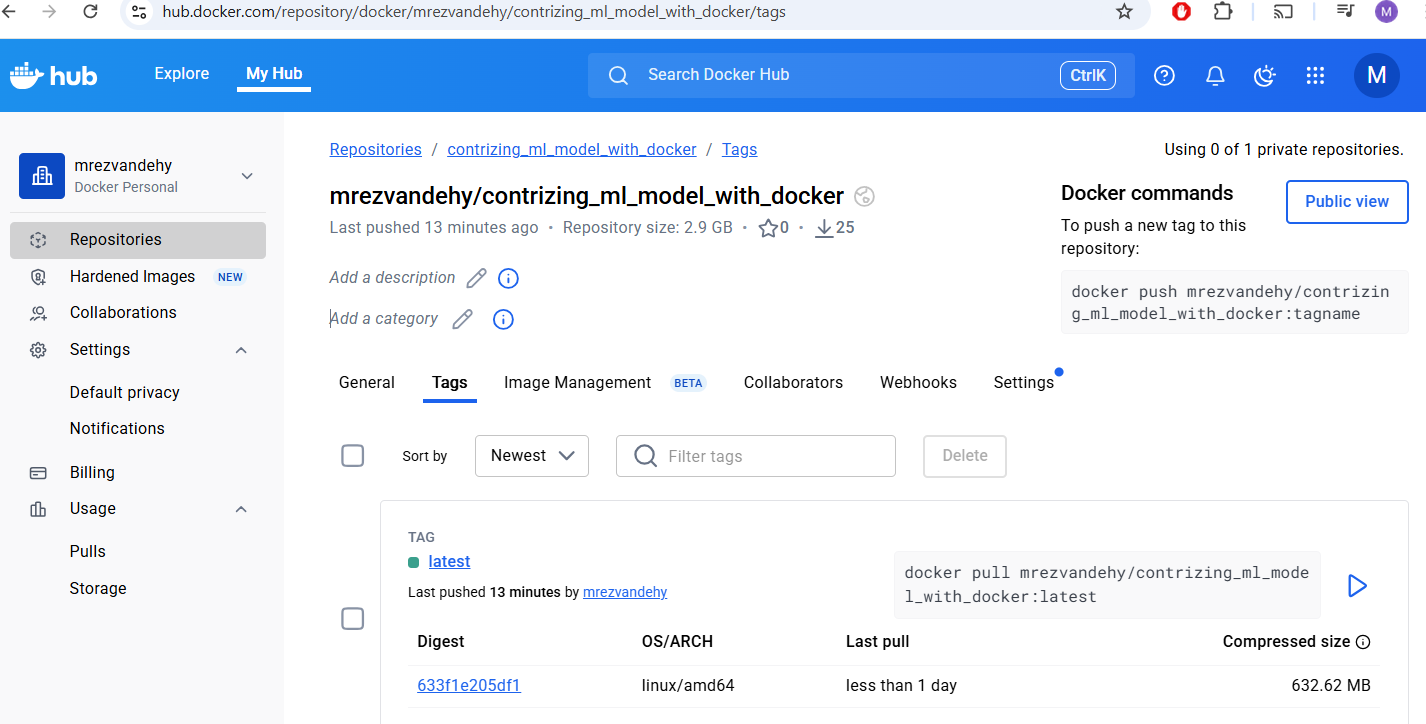

# Deploy containerized Streamlit app on Hugging Face

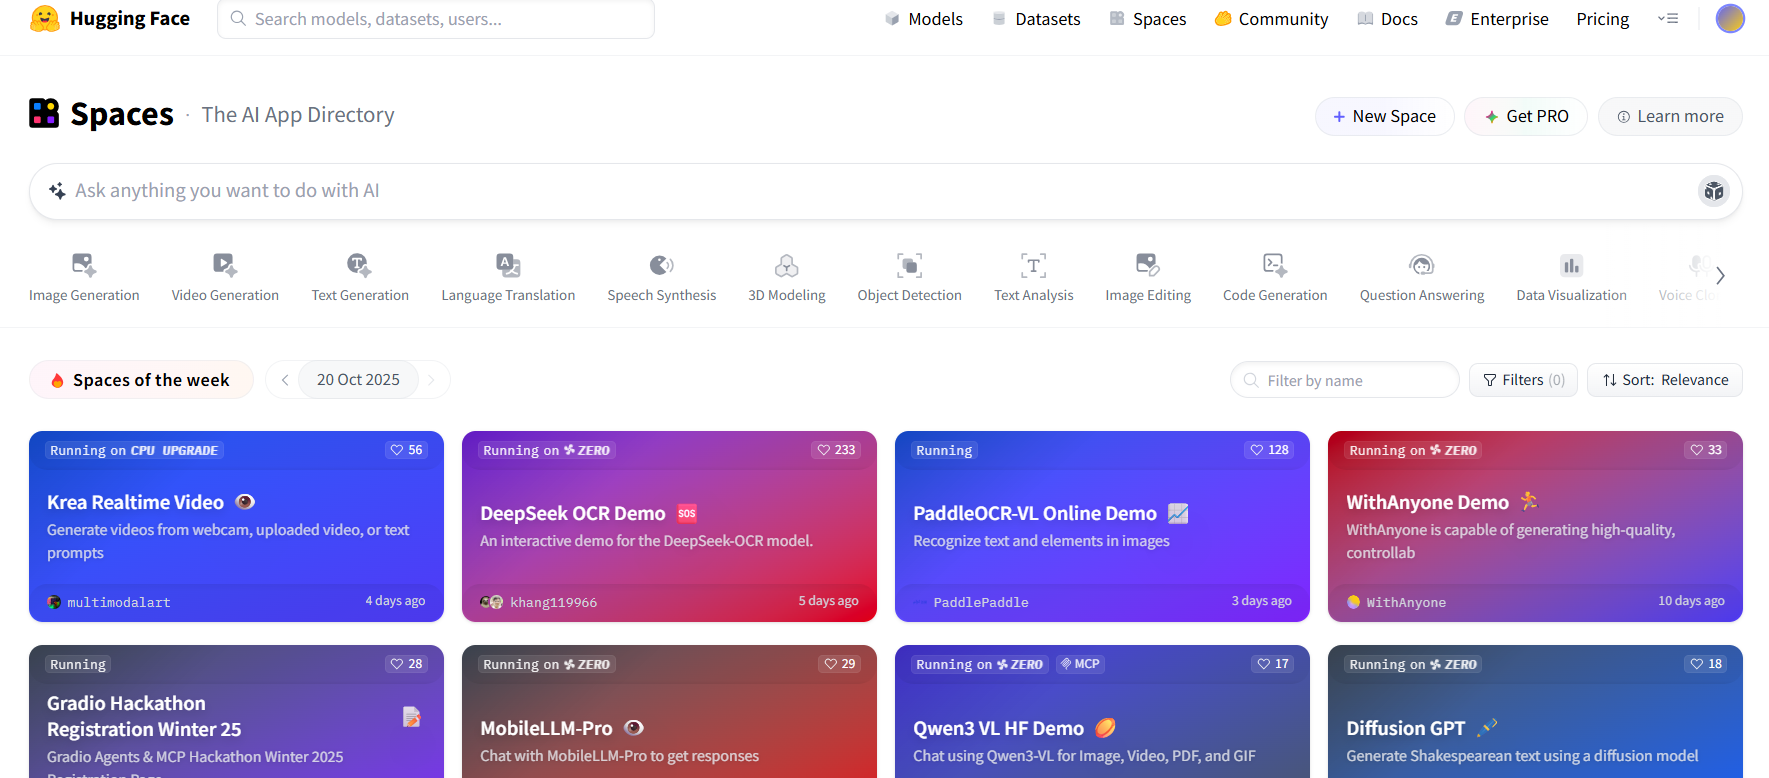

We should select the right type of space which is Docker for our case, fillout the instruction and then create the space

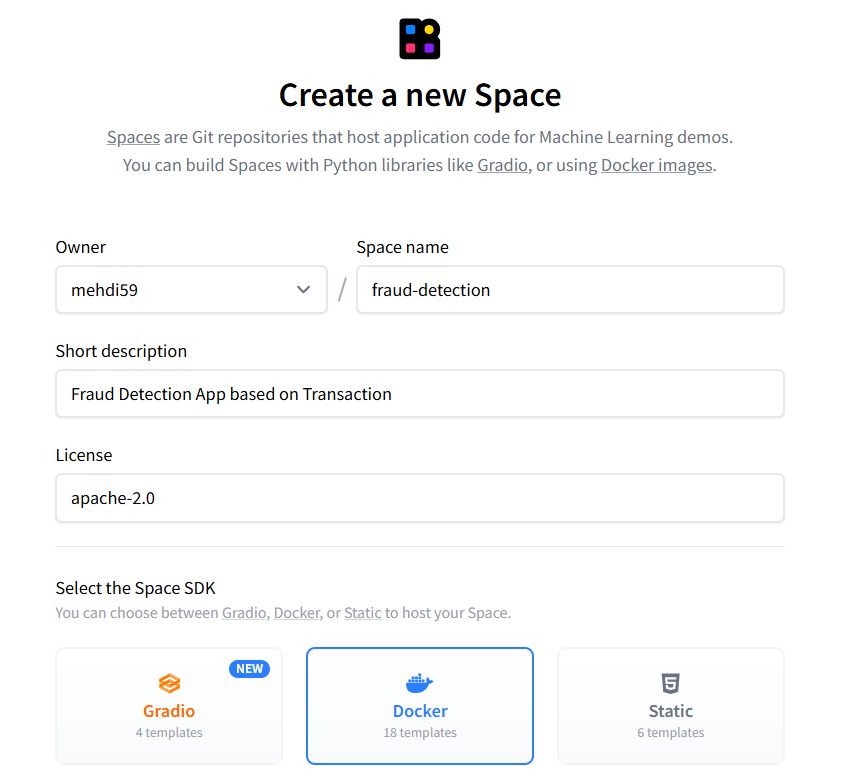

Here is created Space:

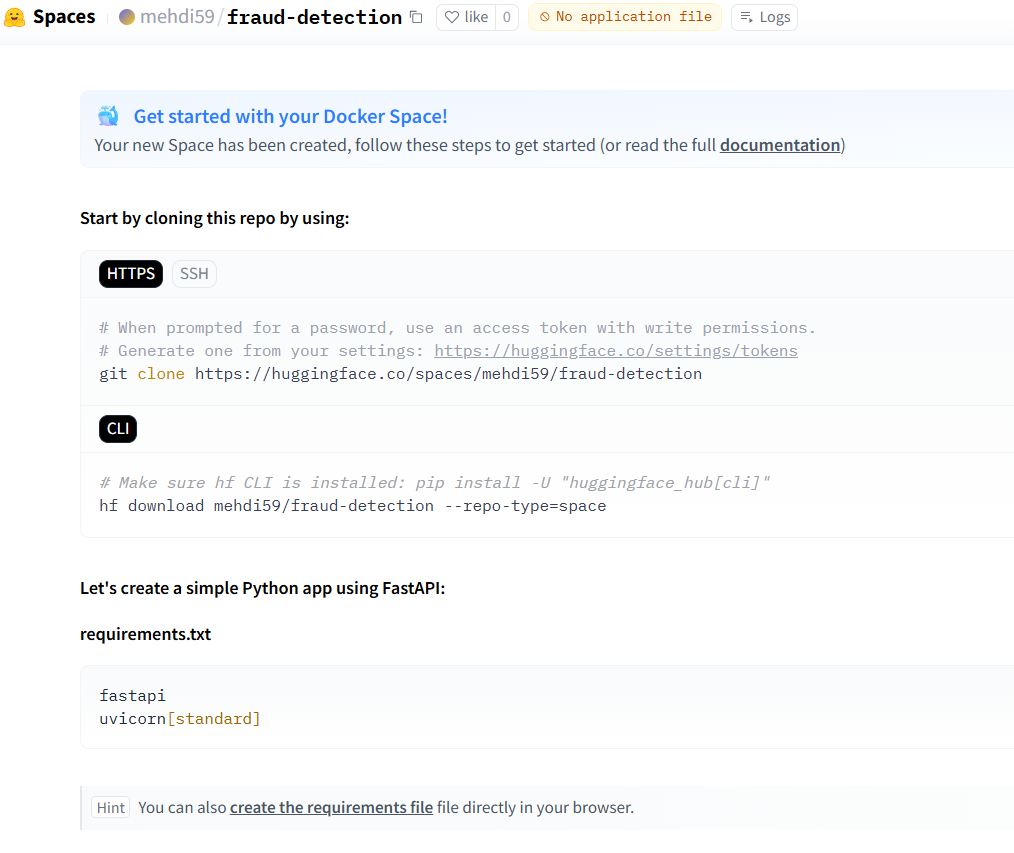

One option is to clone this space: https://huggingface.co/spaces/mehdi59/fraud-detection and add your code to it. That is one option. Another option is to upload your file directly here:

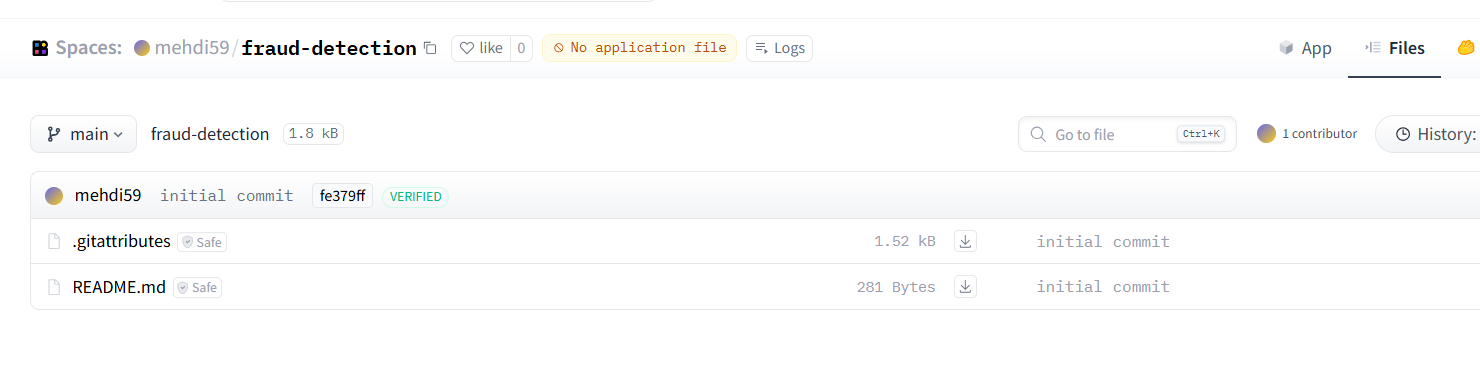

This has a `README.md`:
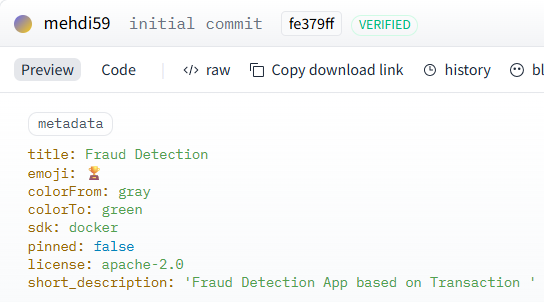

To make it simple, create this https://huggingface.co/spaces/mehdi59/fraud-detection as a remote for our repository, check in everything in repository and push it to this particular repo using `git remote add`. First we want to know what remote exits using `git remote show`. Currently, there is only `origin` which is GitHub repository:

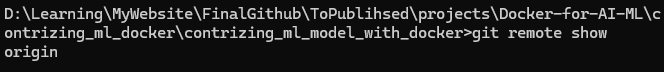

To show origin, use command `git remote show origin`:
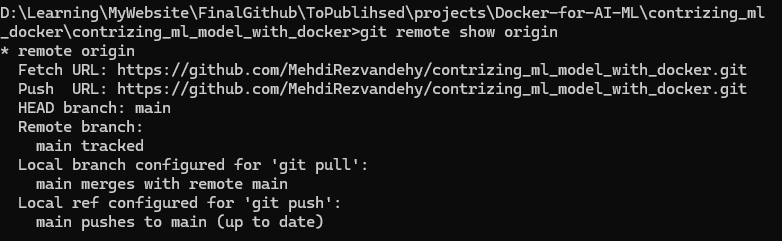

Now we can add hugging face repository as remote by `git remote add hf https://huggingface.co/spaces/mehdi59/fraud-detection` where hf is the name we assigned. Now we have two remotes one origin and another on hf:

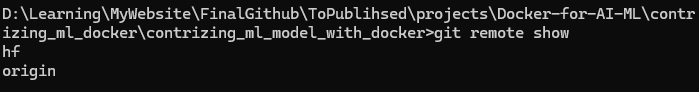
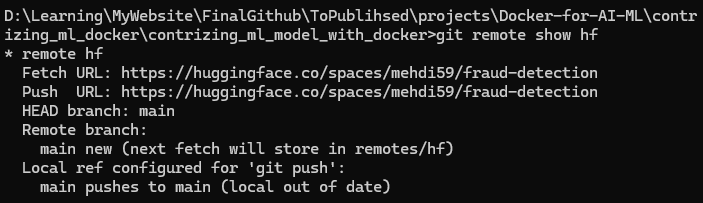

Next is to push all the code to HuggingFace by force push changes `git push hf --force`. Then the app start building on HuggingFace by creating an image from Dockerfile and publishing on its own internal registry It also starts the applition as it is included in Dockerfile:

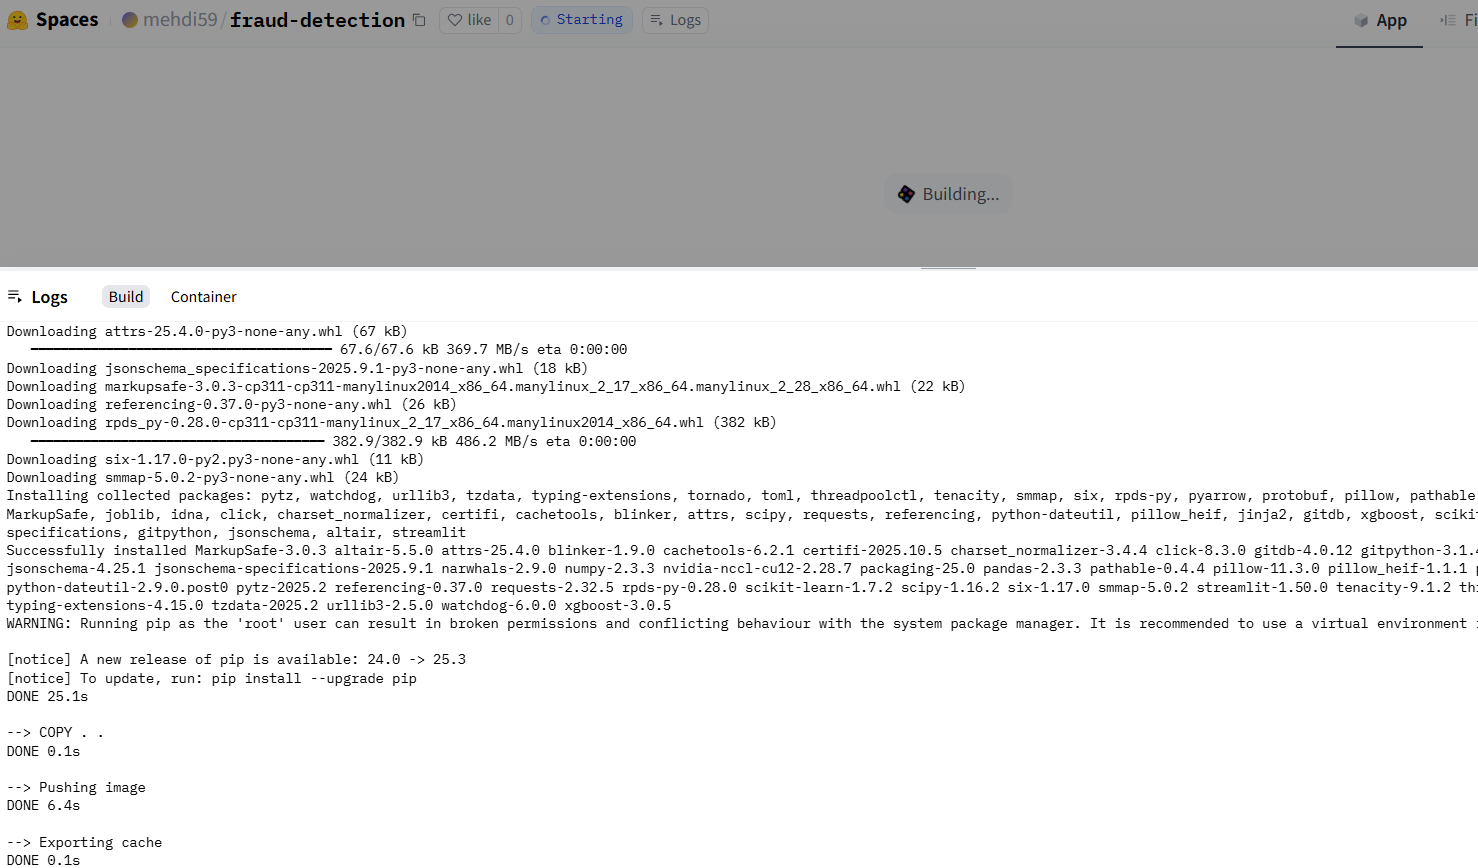

The app has been deployed on Huggingface on https://huggingface.co/spaces/mehdi59/fraud-detection:
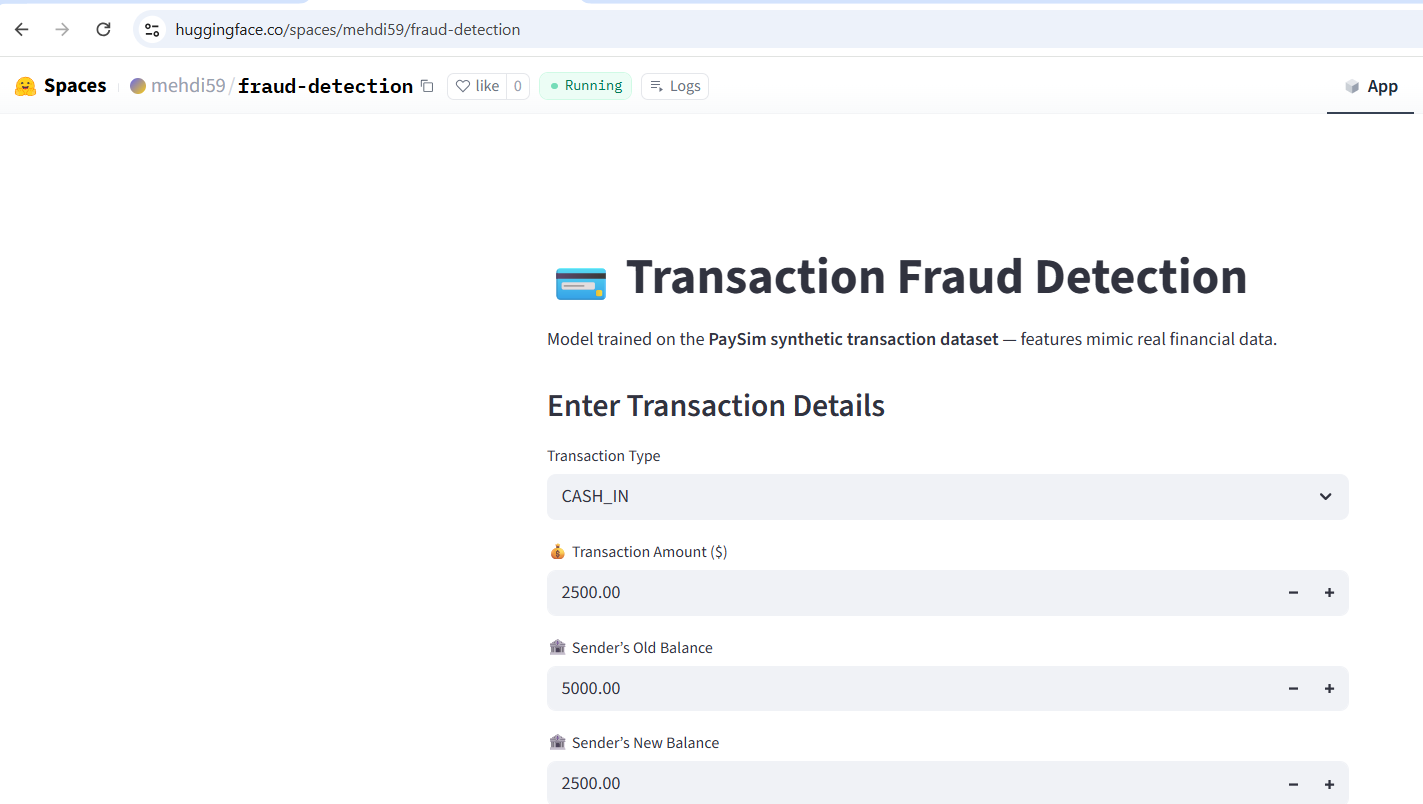    